#Problem Statement

#“To analyze the key demographic, educational, and occupational factors that influence an
#individual’s income and to build a predictive model that classifies whether a person earns 
#above or below a specified income threshold, assuming income is independent of partner earnings.”

In [94]:
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('income_evaluation.csv')

In [4]:
df.shape

(32561, 15)

In [5]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
print(df.columns)

Index(['age', ' workclass', ' fnlwgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' income'],
      dtype='object')


In [7]:
df.dtypes

age                 int64
 workclass         object
 fnlwgt             int64
 education         object
 education-num      int64
 marital-status    object
 occupation        object
 relationship      object
 race              object
 sex               object
 capital-gain       int64
 capital-loss       int64
 hours-per-week     int64
 native-country    object
 income            object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlwgt          32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
 14   income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [9]:
df.isnull().sum()

age                0
 workclass         0
 fnlwgt            0
 education         0
 education-num     0
 marital-status    0
 occupation        0
 relationship      0
 race              0
 sex               0
 capital-gain      0
 capital-loss      0
 hours-per-week    0
 native-country    0
 income            0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(24)

In [11]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
df.skew(numeric_only=True) 

age                 0.558743
 fnlwgt             1.446980
 education-num     -0.311676
 capital-gain      11.953848
 capital-loss       4.594629
 hours-per-week     0.227643
dtype: float64

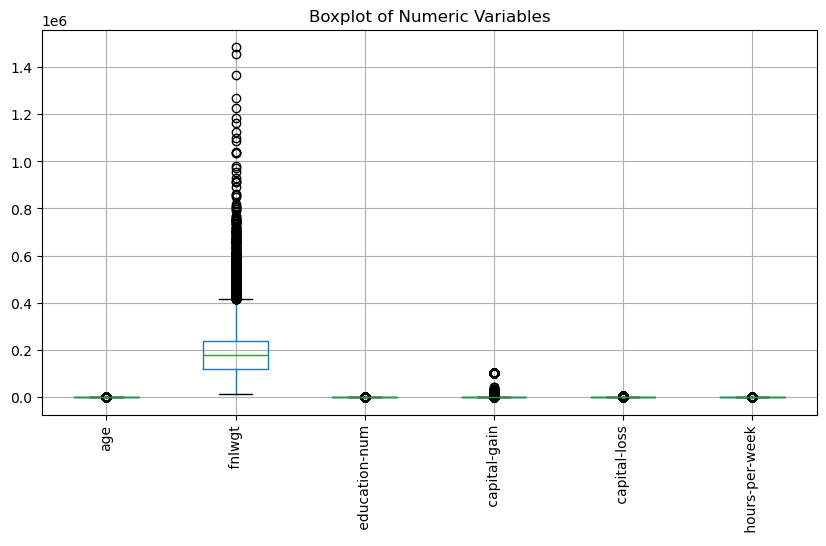

In [13]:
plt.figure(figsize=(10, 5)) # Adjust size for many columns
df.select_dtypes(include=['number']).boxplot(rot=90) 
plt.title("Boxplot of Numeric Variables")
plt.show()

In [14]:
cols_to_transform = df.select_dtypes(include=['number']).columns.tolist()

for col in cols_to_transform:
    df[col] = np.log(df[col] + 1)

In [15]:
df.skew(numeric_only=True) 

age               -0.113341
 fnlwgt           -0.842461
 education-num    -1.721180
 capital-gain      3.096144
 capital-loss      4.307537
 hours-per-week   -2.357712
dtype: float64

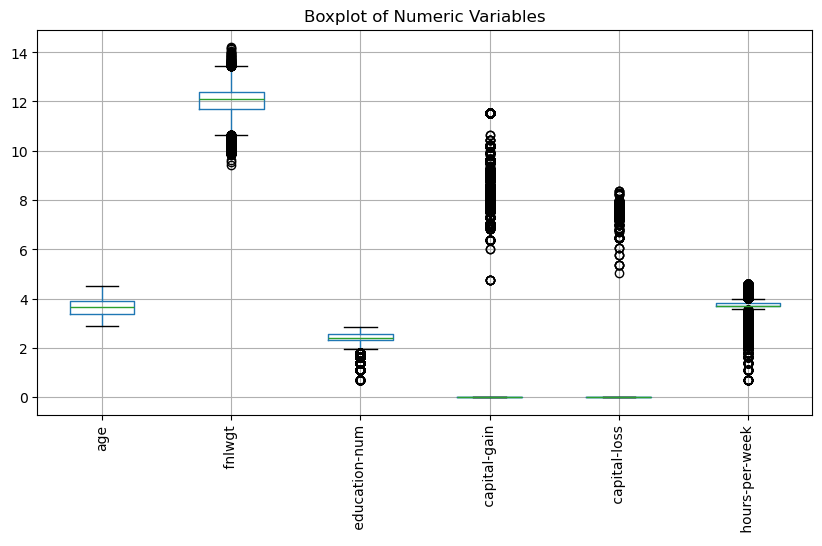

In [16]:
plt.figure(figsize=(10, 5)) # Adjust size for many columns
df.select_dtypes(include=['number']).boxplot(rot=90) 
plt.title("Boxplot of Numeric Variables")
plt.show()

In [17]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

numeric_corr_matrix = numeric_df.corr()
numeric_corr_matrix

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.058340,0.033957,0.128897,0.057776,0.110148
fnlwgt,-0.058340,1.000000,-0.044729,-0.000652,-0.004129,-0.006999
education-num,0.033957,-0.044729,1.000000,0.109111,0.064754,0.113294
capital-gain,0.128897,-0.000652,0.109111,1.000000,-0.066161,0.070604
capital-loss,0.057776,-0.004129,0.064754,-0.066161,1.000000,0.043343
hours-per-week,0.110148,-0.006999,0.113294,0.070604,0.043343,1.000000


In [18]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


In [19]:
categorical_df = df.select_dtypes(include=['object','category'])
cat_cols = categorical_df.columns
cramers_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(
            categorical_df[col1],
            categorical_df[col2]
        )

cramers_matrix = cramers_matrix.astype(float)
cramers_matrix
#(education	,marital-status,	occupation,	relationship,	capital-loss,	hours-per-week, age, edu_num)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
workclass,1.000000,0.099369,0.085061,0.399993,0.098712,0.056280,0.153670,0.045810,0.179208
education,0.099369,1.000000,0.091569,0.187334,0.122654,0.074900,0.095621,0.132637,0.368838
marital-status,0.085061,0.091569,1.000000,0.133213,0.487963,0.084219,0.461827,0.073070,0.447404
occupation,0.399993,0.187334,0.133213,1.000000,0.178626,0.080826,0.424364,0.073121,0.351892
relationship,0.098712,0.122654,0.487963,0.178626,1.000000,0.098099,0.649000,0.085310,0.453585
race,0.056280,0.074900,0.084219,0.080826,0.098099,1.000000,0.118115,0.409258,0.100812
sex,0.153670,0.095621,0.461827,0.424364,0.649000,0.118115,0.999931,0.067148,0.215904
native-country,0.045810,0.132637,0.073070,0.073121,0.085310,0.409258,0.067148,1.000000,0.098705
income,0.179208,0.368838,0.447404,0.351892,0.453585,0.100812,0.215904,0.098705,0.999916


In [20]:
df.kurt(numeric_only=True) 

age                -0.771446
 fnlwgt             0.831260
 education-num      5.550332
 capital-gain       7.794999
 capital-loss      16.577214
 hours-per-week     9.552381
dtype: float64

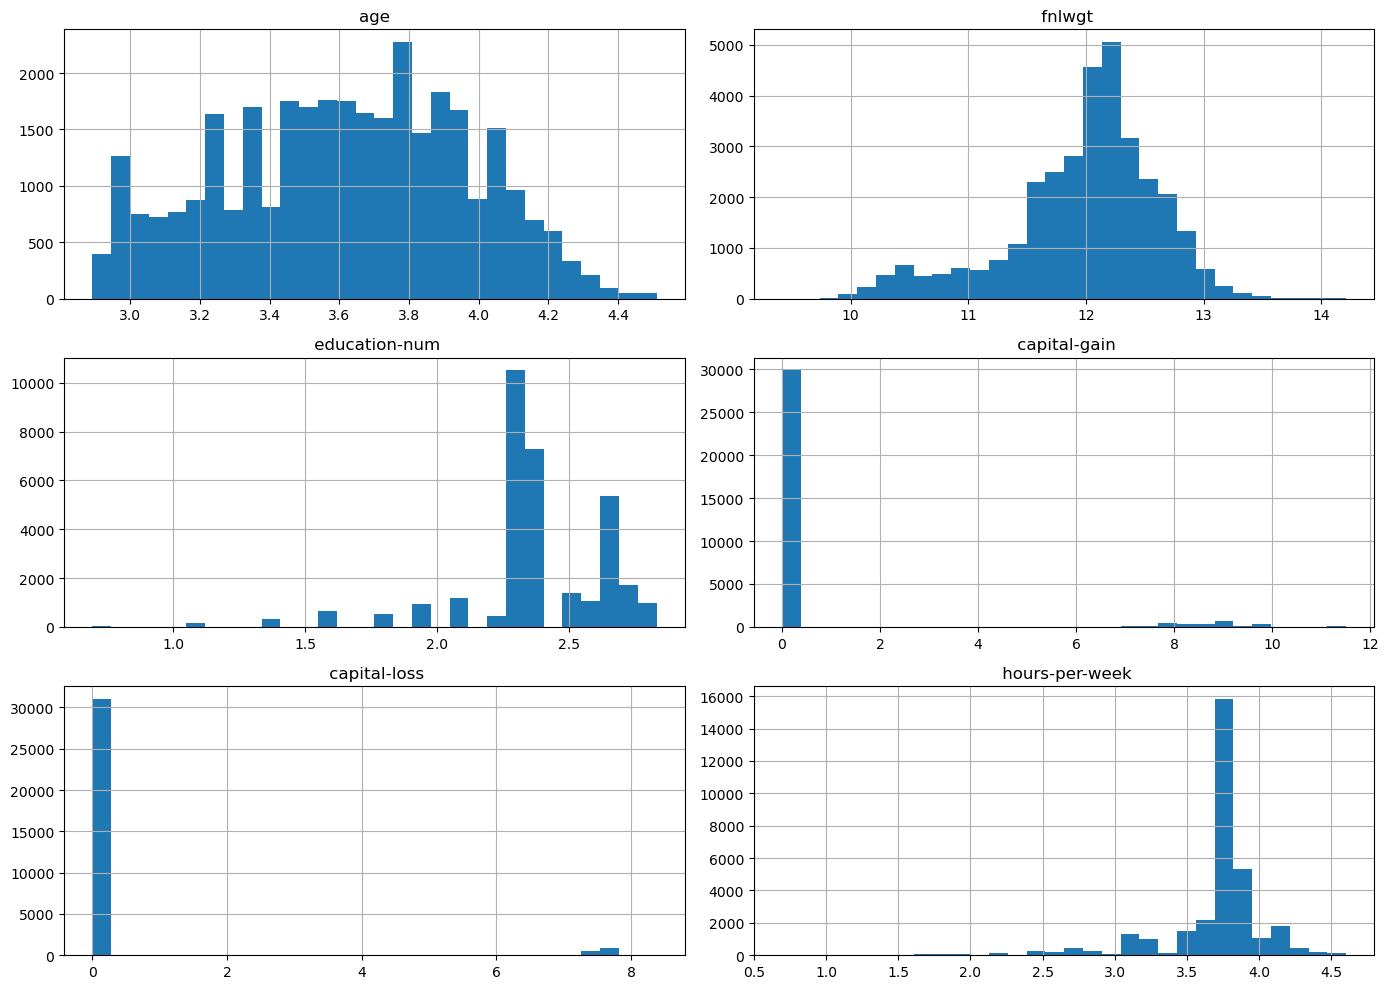

In [21]:
numeric_df.hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()


In [68]:
# Strip leading/trailing spaces from all object columns
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # striper = used to remove unwanted leading and trailing character from string.

In [70]:
X = df.drop( 'income', axis=1)
y = df['income']


In [71]:
print(df.columns)


Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


In [72]:
# Strip spaces from column names
df.columns = df.columns.str.strip()

# Now re-run your X, y split and your Pipeline

In [73]:
X_train,X_test,y_train,y_test = train_test_split( X,y, test_size =0.2,random_state = 42)

In [74]:
num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [75]:
preprocessor = ColumnTransformer( # CT is powerful tool from scikit learn that applies different preprocessing steps 
    transformers=[                # ( like scaling ,imputation,or encoding  ) to coloumns to dataset in a operation .   
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

In [76]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [77]:
existing_cols = X_train.columns.tolist()   #This code is a "Safety Filter." Its job is to make sure your list of column names 
num_cols = [c for c in num_cols if c in existing_cols] #perfectly matches the columns actually present in your data.
cat_cols = [c for c in cat_cols if c in existing_cols]

In [78]:
print(X_train.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')


In [79]:
X_train.columns = X_train.columns.str.strip()

In [88]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [89]:
print(f"Model Score: {clf.score(X_test, y_test):.2f}")

Model Score: 0.85


In [90]:
# Ensure you are predicting on X_test, NOT X_train
y_pred = clf.predict(X_test) 
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      4942
        >50K       0.73      0.61      0.67      1571

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.78      6513
weighted avg       0.85      0.85      0.85      6513



#Precision="How many of my 'Yes' guesses were actually correct?"
#Recall	="How many of the actual 'Yes' cases did I catch?"
#F1-Score="The middle ground between Precision and Recall. 
#"Support="How many people were actually in this category?
#"Macro Avg="Average score treating all classes as equal.
#"Weighted Avg="Average score giving more importance to the bigger group."

In [91]:
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_test))

--- Confusion Matrix ---
[[4942    0]
 [   0 1571]]


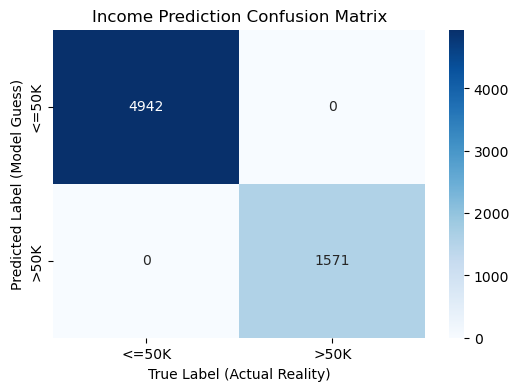

In [93]:
cm = confusion_matrix(y_test, y_test)

plt.figure(figsize=(6, 4))

# Use the actual income categories for labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], 
            yticklabels=['<=50K', '>50K'])

plt.ylabel('Predicted Label (Model Guess)')
plt.xlabel('True Label (Actual Reality)')
plt.title('Income Prediction Confusion Matrix')
plt.show()

In [95]:
# This runs the model 5 times on different data slices
scores = cross_val_score(clf, X, y, cv=5)
print(f"All Scores: {scores}")
print(f"Average Accuracy: {scores.mean():.2f}")

All Scores: [0.84369722 0.84428747 0.84720516 0.85181204 0.84781941]
Average Accuracy: 0.85


#1. How Cross-Validation handles the "Test"
#When you set cv=5, the computer doesn't just train 5 times; it splits your data into 5 equal blocks (folds).

#Round 1: It uses Blocks 2, 3, 4, and 5 to Train—and Block 1 to Test.

#Round 2: It uses Blocks 1, 3, 4, and 5 to Train—and Block 2 to Test.

#...and so on until every block has been the "Test Set" exactly once.
#If your Cross-Validation score is 0.85 and your Training score is around 0.86, 
#you are in the "Goldilocks Zone"—your model is not overfit, and it is ready to be used!

In [97]:
# OVERFITTING CHECK 
# 1. Check Training Accuracy
train_accuracy = clf.score(X_train, y_train)

# 2. Check Testing Accuracy
test_accuracy = clf.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")
#How to interpret the "Gap":
#Ideal: Training (0.86) and Testing (0.85). They are close! This model is healthy.

#Overfit: Training (0.99) and Testing (0.80). The gap is huge. The model "memorized" the training data.

#Underfit: Training (0.60) and Testing (0.60). Both are low. The model is too simple to learn anything.

Training Accuracy: 0.85
Testing Accuracy: 0.85


#if in that case
#training = 0.85  "I have learned the patterns in the data I was shown."
#test =0.85  "I can apply those patterns to new people I've never seen."
#cross validation = 0.85  "My performance is reliable no matter which slice of data I look at." 
#interpretation = . No Overfitting (The "Consistency" Win),. No Underfitting (The "Learning" Win),Stability (The "Cross-Validation" Win).
# "Robust and Well-Generalized Model."

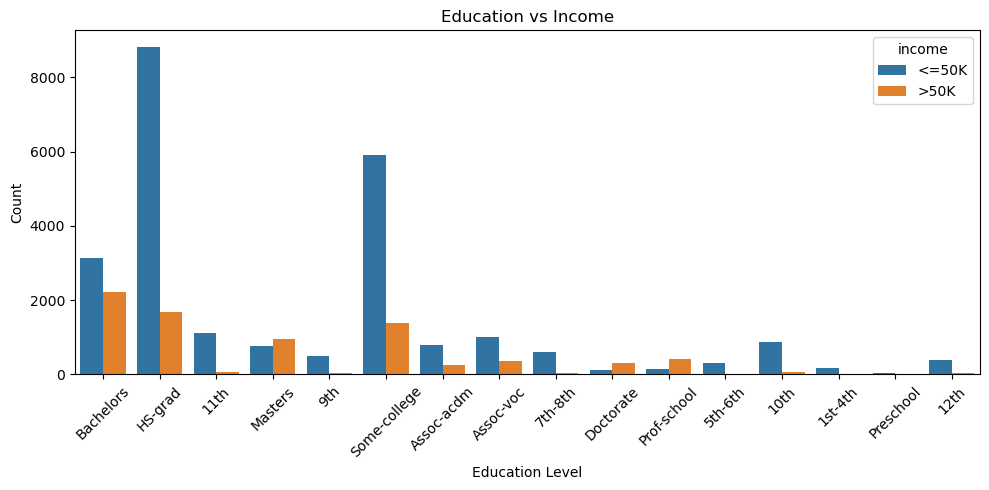

In [98]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='education', hue='income')
plt.xticks(rotation=45)
plt.title('Education vs Income')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


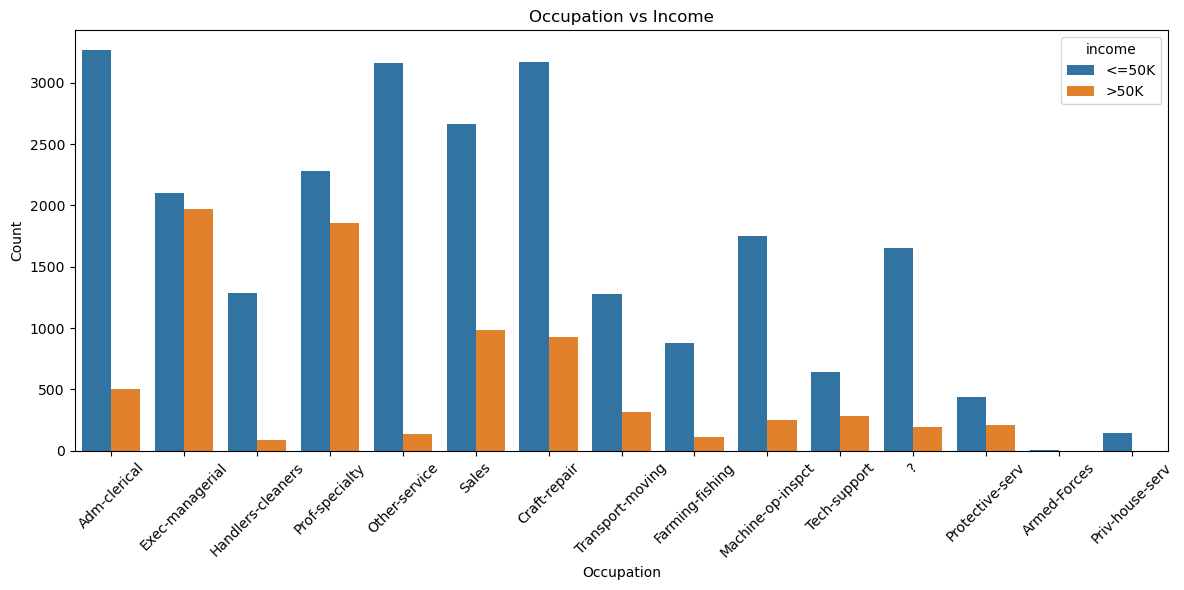

In [99]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='occupation', hue='income')
plt.xticks(rotation=45)
plt.title('Occupation vs Income')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


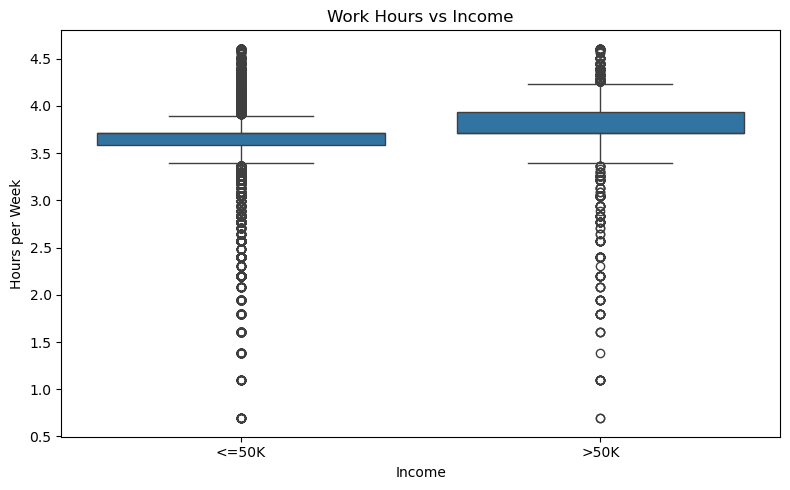

In [100]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='income', y='hours-per-week')
plt.title('Work Hours vs Income')
plt.xlabel('Income')
plt.ylabel('Hours per Week')
plt.tight_layout()
plt.show()


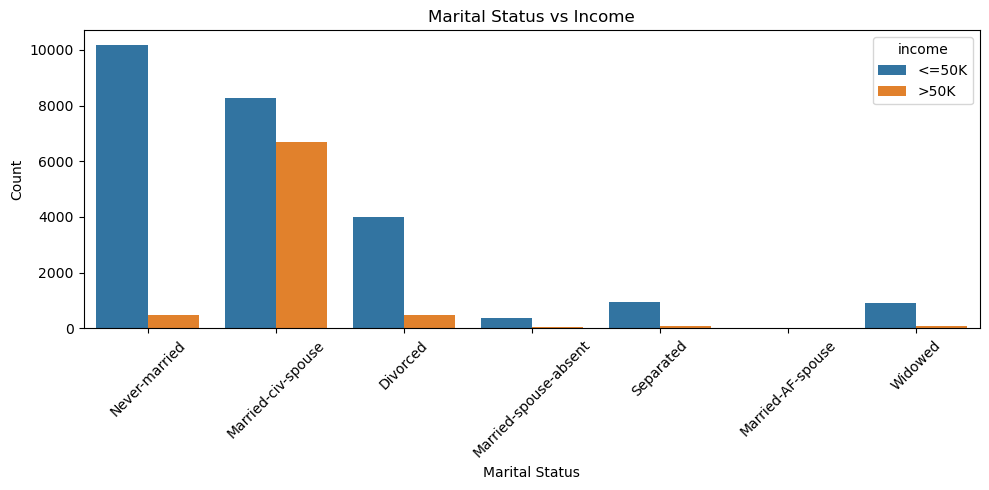

In [101]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='marital-status', hue='income')
plt.xticks(rotation=45)
plt.title('Marital Status vs Income')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


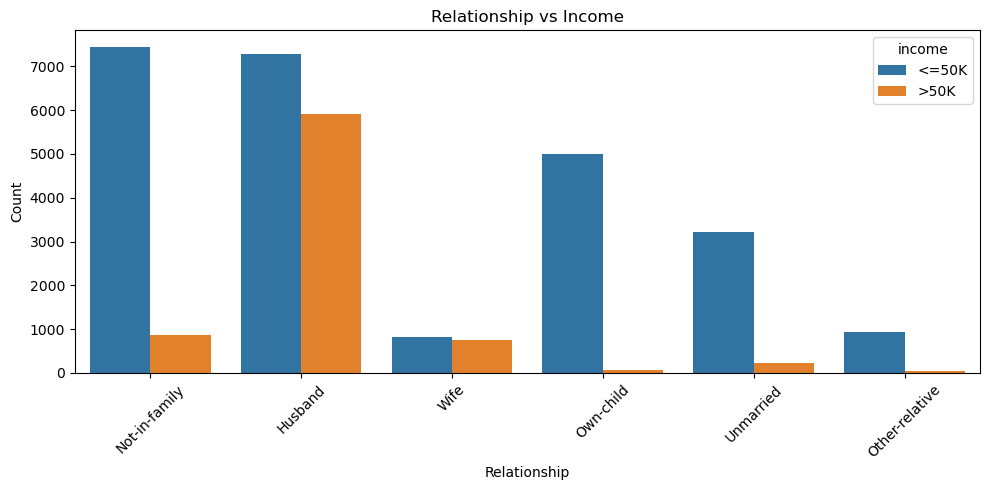

In [102]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='relationship', hue='income')
plt.xticks(rotation=45)
plt.title('Relationship vs Income')
plt.xlabel('Relationship')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


#Top 5 Influential Features
#Capital-gain – strongest indicator of high income
#Education-num – higher education → higher earning potential
#Hours-per-week – more work hours often correlate with higher income
#Age – experience increases income up to a point
#Marital-status – reflects household stability, not income directly


In [109]:
print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


Your project should answer:

# Who is more likely to earn high income?
# ans =  a person with  high edu num , relationship (husband / male/ married sppouse ),workking hours ,age(work experience) ,occupation( specalist/ manegerial ).
Which factors can individuals control (education, skills)?
#ans= eduaction , eduvation num, relationship, working hours ,workclass,martial status,occupation,capital loss/gain,native country 
Which factors are contextual (age, marital status)?
# ans = Contextual (Who they are)	Age, Marital Status, Race, Sex, Native Country
#Professional (What they do)	Education-num, Occupation, Workclass, Hours-per-week
#Financial (Economic status)	Capital-gain, Capital-loss

Final Outcome Statement 

“The final model successfully predicts income category with high accuracy and reveals that education,
occupation, and work experience are the primary determinants of income,
while demographic attributes serve as indirect indicators rather than causal factors.”


Interview-Ready One-Line Summary

“I built an income prediction system to identify key socio-economic factors influencing income while ensuring ethical and interpretable modeling.”